## Testing:

Demonstrate the enccodings by adding some ambiguization noise and see their decoded outputs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/4995_final_project/'

/content/drive/MyDrive/4995_final_project


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import  DataLoader
from torchvision import utils
#
import dataTools as D
import tools as T
#
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from cv2 import imwrite, imread, IMWRITE_JPEG_QUALITY, COLOR_BGR2RGB
%precision 4

'%.4f'

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
  torch.cuda.empty_cache()

True
1
cuda:0


### Initialize data

In [ ]:
def generate_img_names_list(n):
    res = []
    
    for i in range(1, n+1):
        num_zeros = len(str(202599)) - len(str(i))
        res.append('0'*num_zeros + str(i) + '.jpg')
    return res

In [ ]:
# !ls data/img_align_celeba/img_align_celeba

In [ ]:
# Generate list of shuffled file names that correspond to train, validate, test and save them
import random

nCeleb = 96 # 202599
files = generate_img_names_list(nCeleb)
shuffled_files = random.sample(files, len(files))
database_name = 'CelebA'

if database_name == 'CelebA':
    batch_size = 100
    root = 'data/img_align_celeba/img_align_celeba'
    # img_names_list_train = shuffled_files[0 : int(0.8*nCeleb)]
    # img_names_list_valid = shuffled_files[int(0.8*nCeleb)+1 : int(0.9*nCeleb)]
    # img_names_list_test = shuffled_files[int(0.9*nCeleb)+1: ]
    img_names_list_test = shuffled_files
    img_size = (3, 128, 128)
elif database_name == 'CYale':
    root = '/path/to/CYale/'
    img_names_list_test = './dataset_splits/CYale/CYale_test.txt'  
    img_size = (1, 168, 192)
num_channel = img_size[0]   

### Initialize data representation for dataloader

In [ ]:
num_epoch = 10
batch_size = 16

dataset = D.imgRead_fromList(root, img_names_list_test, img_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Loading the trained model:

In [ ]:
model_path = './weights/best_model_stmp1670216340.866353.pth'
num_blocks = 5
num_filts = [64, 128, 256, 512, 12]
scale_factor = [1, 1, 1, 1, 1]
num_codes = 20
neck_dim = 512
k = 256

#######
from models import Autoencoder
net = Autoencoder(img_size, num_blocks, num_filts, scale_factor, num_codes, neck_dim, k)
net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()
net.to(device)

Autoencoder(
  (encoder): Encoder(
    (downBlocks_I): ModuleList(
      (0): downConvBlock_I(
        (resConv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=4)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): downConvBlock_I(
        (resConv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=4)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): downConvBlock_I(
        (resConv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
from torchsummary import summary
print(summary(net.encoder, (3, 128, 128))) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 128, 128]              48
            Conv2d-2          [-1, 3, 128, 128]              84
            Conv2d-3          [-1, 3, 128, 128]             228
            Conv2d-4         [-1, 12, 128, 128]              48
       BatchNorm2d-5         [-1, 12, 128, 128]              24
  downConvBlock_II-6         [-1, 12, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]             256
            Conv2d-8         [-1, 64, 128, 128]           1,792
            Conv2d-9         [-1, 64, 128, 128]          25,664
      BatchNorm2d-10         [-1, 64, 128, 128]             128
  downConvBlock_I-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 12, 128, 128]             780
           Conv2d-13         [-1, 64, 128, 128]          36,928
           Conv2d-14         [-1, 64, 1

### Run the network on the test set:

In [ ]:
# Here we load only one mini-batch:
with torch.no_grad():
    for i, inp in enumerate(dataloader):
      try:
          inp = inp['image'].to(device) 
          out, code = net(inp)
          out.sigmoid_()
          break
      except FileNotFoundError:
          print('File not found.')

### Visualization and evaluation of the reconstruction performance:

(3, 128, 128)


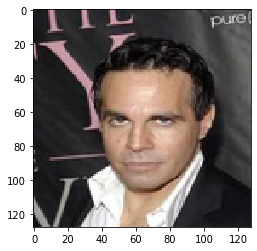

(3, 128, 128)


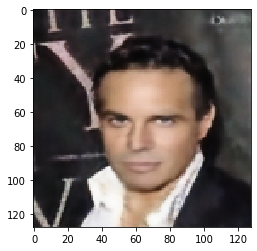

tensor(0.0087, device='cuda:0')


In [ ]:
idx = 0 # To show
ind_i = 0  # To save
D.imShow(inp, idx=idx)
D.imShow(out, idx=idx)

print(torch.norm(inp[idx] - out[idx]).pow(2)/torch.norm(inp[idx]).pow(2))
utils.save_image(inp[ind_i:ind_i + 8,:,:,:], 'output/input_1.png', nrow=8)
utils.save_image(out[ind_i:ind_i + 8,:,:,:], 'output/reconstructed_1.png', nrow=8)

### Effect of sparsity on the reconstruction performance:

(3, 128, 128)


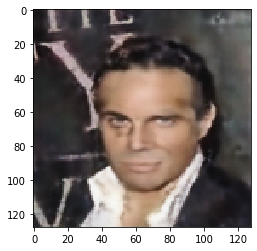

tensor(0.0131, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
# Decoding with less sparsity:
code_prime = torch.clone(code).to(device).detach()
code_prime = T.KBest(code_prime, 128)
out_prime = net.decoder(code_prime.to(device)).sigmoid_()

D.imShow(out_prime, idx=idx)
print(torch.norm(inp - out_prime).pow(2)/torch.norm(inp).pow(2))
utils.save_image(out_prime[ind_i:ind_i + 8,:,:,:], 'output/k_64_2.png', nrow=8)

### To see the characteristics of code-maps:

In [ ]:
torch.cuda.empty_cache()

(3, 128, 128)


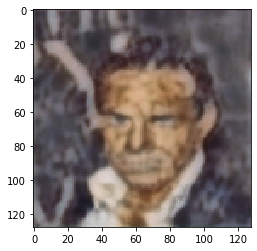

In [ ]:
# Putting some of the code-maps to zero:
# First 12 characteristics of the coded representation
idx = 0
ind_i = 0
code_prime = torch.clone(code).to(device).detach()
i_s = 0
i_e = 12

code_prime[:,i_s:i_e,:] = 0
out_prime = net.decoder(code_prime.to(device)).sigmoid_()

D.imShow(out_prime, idx=idx)
utils.save_image(out_prime[ind_i:ind_i + 8,:,:,:], 'output/zero_1.png', nrow=8)

(3, 128, 128)


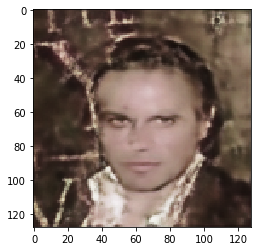

In [ ]:
# Putting some other code-maps to zero:
# Set characteristics 12-20 of code representation. to0
code_prime = torch.clone(code).to(device).detach()
i_s = 12
i_e = 20
code_prime[:,i_s:i_e,:] = 0
out_prime = net.decoder(code_prime.to(device)).sigmoid_()
D.imShow(out_prime, idx=idx)
utils.save_image(out_prime[ind_i:ind_i + 8,:,:,:], 'output/zero_2.png', nrow=8)

### Ambiguation:

code type:  <class 'torch.Tensor'>
b, c, m:  16 20 512
zs:  tensor([[  0,   0,   0],
        [  0,   0,   1],
        [  0,   0,   3],
        ...,
        [ 15,  19, 507],
        [ 15,  19, 509],
        [ 15,  19, 510]])
torch.Size([16, 20, 512])
(16, 20, 512)


<Figure size 432x288 with 0 Axes>

(3, 128, 128)


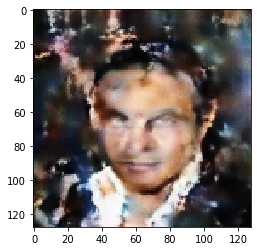

In [ ]:
# Ambiguation noise on the complement of support:
# Note that the number of added noise values is k_prime - k.
k_prime = 2*k
code_tilde = torch.clone(code).cpu().detach()
code_tilde = T.ambiguate(code_tilde, k_prime=k_prime)
out_tilde = net.decoder(code_tilde.to(device)).sigmoid_()
D.imShow(code, idx=idx)
D.imShow(out_tilde, idx=idx)
utils.save_image(out_tilde[ind_i:ind_i + 8,:,:,:], 'output/ambiguated.png', nrow=8)

### Attacks:

As a very basic attack, here we randomly put $k$ out of $k'$ non-zero values to zero. Without any extra knowledge, the adversary has to make $k' \choose k$ such guesses to reconstruct the original image.

(3, 128, 128)


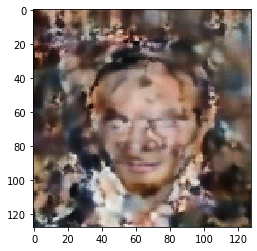

In [ ]:
# Randomly selecting k out of k':
code_hat = torch.clone(code_tilde).cpu().detach()
code_hat = T.random_guess(code_hat, k)
out_hat = net.decoder(code_hat.to(device)).sigmoid_()
D.imShow(out_hat, idx=idx)
utils.save_image(out_hat[ind_i:ind_i + 8,:,:,:], 'output/disambiguated.png', nrow=8)

#### Quantitative quality assessment:

* PSNR
* SSIM

In [ ]:
# peak_signal_noise_ratio, structural_similarity

psnr_outputs = []
ssim_outputs = []

psnr_output_primes = []
ssim_output_primes = []

psnr_tildes = []
ssim_tildes = []

psnr_hats = []
ssim_hats = []

for i in range(inp.shape[0]):
    psnr_outputs.append(
        peak_signal_noise_ratio(
        inp[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(),
        out[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy()) )
    
    ssim_outputs.append(
        structural_similarity(
        inp[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(),
        out[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(), multichannel=True) )
    
    
    psnr_output_primes.append(
        peak_signal_noise_ratio(
        inp[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(),
        out_prime[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy()) )
    
    ssim_output_primes.append(
        structural_similarity(
        inp[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(),
        out_prime[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(), multichannel=True) )
    
    
    psnr_tildes.append(
        peak_signal_noise_ratio(
        inp[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(),
        out_tilde[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy()) )
    
    ssim_tildes.append(
        structural_similarity(
        inp[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(),
        out_tilde[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(), multichannel=True) )
    
    
    psnr_hats.append(
        peak_signal_noise_ratio(
        inp[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(),
        out_hat[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy()) )
    
    ssim_hats.append(
        structural_similarity(
        inp[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(),
        out_hat[i,:,:,:].squeeze(0).transpose(0,2).cpu().detach().numpy(), multichannel=True) )
    
    
############################    
print(np.mean(psnr_outputs))
print(np.mean(ssim_outputs))

print(np.mean(psnr_output_primes))
print(np.mean(ssim_output_primes))

print(np.mean(psnr_tildes))
print(np.mean(ssim_tildes))

print(np.mean(psnr_hats))
print(np.mean(ssim_hats))    

27.354518625243976
0.9003250977729222
17.72214305444615
0.7182053704615047
18.15054088318528
0.5951288708418586
15.01002298424006
0.4364452631248505


In [ ]:
psnr_jpg = []
ssim_jpg = []
for i in range(inp.shape[0]):
    
    img = inp[i,:,:,:].squeeze(0).transpose(0,2).cpu().numpy() 
    imwrite('tmp.jpg', img * 256, [IMWRITE_JPEG_QUALITY, 4])
    image = imread('tmp.jpg' , COLOR_BGR2RGB)
    image = image.astype('float32')/256
    psnr_jpg.append(peak_signal_noise_ratio(img, image))
    ssim_jpg.append(structural_similarity(img, image, multichannel=True))

    
print(np.mean(psnr_jpg))
print(np.mean(ssim_jpg))    

In [ ]:
## How many KBytes per compressed image:
print(T.calculate_KBytes(512, 128, 20))

In [ ]:
## The ratio of the compressed image to the key:
print(T.calculate_KBytes(512, 128, 20) / T.calculate_KBytes(k_prime, 128, 20) )